In [385]:
#get notebook runtime
from timeit import default_timer as timer
start = timer()

In [386]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [387]:
import warnings
warnings.filterwarnings('ignore')

In [388]:
# Data Transformation
import pandas as pd
import geopandas as gpd
import numpy as np
import h3
import shapely

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx


# ML Processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

# Neural Networks
from tensorflow import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout

## Data Readin and Helper Functions

In [389]:
# Main Taxi Trip Data
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")
df["PU_isWorkday"]=df["PU_isWorkday"].astype(int) #convert boolean to int for prediction

# a map that outlines the city of chicago
chicago = gpd.read_file("../data/chicago.geojson")

# Data containing Points of Interest
df_poi = pd.read_csv("../data/POI_per_H3.csv")

# Weather Data, pretransformed to be usable for prediction
weather_df = pd.read_parquet("../data/weather_transformed_23_08_2021.parquet")
weather_df["hour"] = weather_df["datetime"].dt.hour+1
weather_df["has_precipitation"] = weather_df["has_precipitation"].astype(int)
weather_df.drop(columns=["month","datetime"],inplace=True)


weather_df_dummies = weather_df.copy()[["date","hour","weather_description"]]
weather_df_dummies = pd.concat([weather_df_dummies,
                                pd.get_dummies(weather_df["weather_description"])],
                               axis=1)

slicer=12
weather_df_dummies["hour_slice"] = np.ceil(weather_df_dummies["hour"]/slicer).astype(int)
weather_df_dummies = weather_df_dummies.drop(columns=["weather_description","hour"])

weather_df_dummies = weather_df_dummies.groupby(["date","hour_slice"]).sum()

weather_df.sample(10)

,Temperature,Humidity,Wind Speed,weather_description,date,has_precipitation,precipitation_intensity,hour
565,275.94,93.0,4.0,overcast clouds,2017-01-24,0,0,14
7266,282.35,57.0,6.0,scattered clouds,2017-10-30,0,0,19
3209,293.81,53.0,2.0,scattered clouds,2017-05-14,0,0,18
7156,277.24,100.0,2.0,light snow,2017-10-26,1,1,5
5023,291.63,49.0,6.0,sky is clear,2017-07-29,0,0,8
6303,296.12,73.0,6.0,mist,2017-09-20,0,0,16
863,275.36,55.0,3.0,broken clouds,2017-02-05,0,0,24
1655,270.70,25.0,4.0,broken clouds,2017-03-10,0,0,24
2831,287.70,77.0,4.0,overcast clouds,2017-04-28,0,0,24
7306,275.23,64.0,2.0,overcast clouds,2017-11-01,0,0,11


In [390]:
#https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
def eval_reg(y_test,y_pred):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].scatter(y_pred, y_test, edgecolors=(0, 0, 1),alpha=0.1)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    ax[1].hist(y_pred-y_test,bins=100)
    plt.show()

    # model evaluation for testing set
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    max_error = sklearn.metrics.max_error(y_test, y_pred)#Calculating Max_Error

    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))
    print('Max error is {}'.format(max_error))

### Characteristics

Let's recall the characteristics of our dataset:

In [391]:
df.shape

(1089891, 43)

In [392]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,12,1,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,15,1,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,8,1,March,Friday,9,2017-03-03,3,4,8,True
14574858,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,11,0,July,Sunday,30,2017-07-23,7,6,11,False
3642582,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,11,0,February,Saturday,8,2017-02-25,2,5,11,False


In [393]:
df.isnull().sum()

Trip ID                            0
Taxi ID                          401
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Census Tract           328349
Dropoff Census Tract          331418
Pickup Community Area          78095
Dropoff Community Area         98584
Fare                               0
Tips                               0
Tolls                         284734
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude       78095
Pickup Centroid Longitude      78095
Dropoff Centroid Latitude      98584
Dropoff Centroid Longitude     98584
PU_H3                          78095
DO_H3                          98584
PU_DISTANCE_CITY               78095
DO_DISTANCE_CITY               98584
DURATION_IN_MINUTES                0
MPH                                0
P

In [394]:
df_pairplot = df[:100]

In [395]:
#sns.pairplot(df_pairplot, hue='PU_H3')

Nun schauen wir uns explizit die Korrelationen der Variablen an. Wie ebenfalls im vorigen Plot zu observieren, sehen wir hier, dass die Variablen zum Teil stark positiv sowie negativ korrelieren.

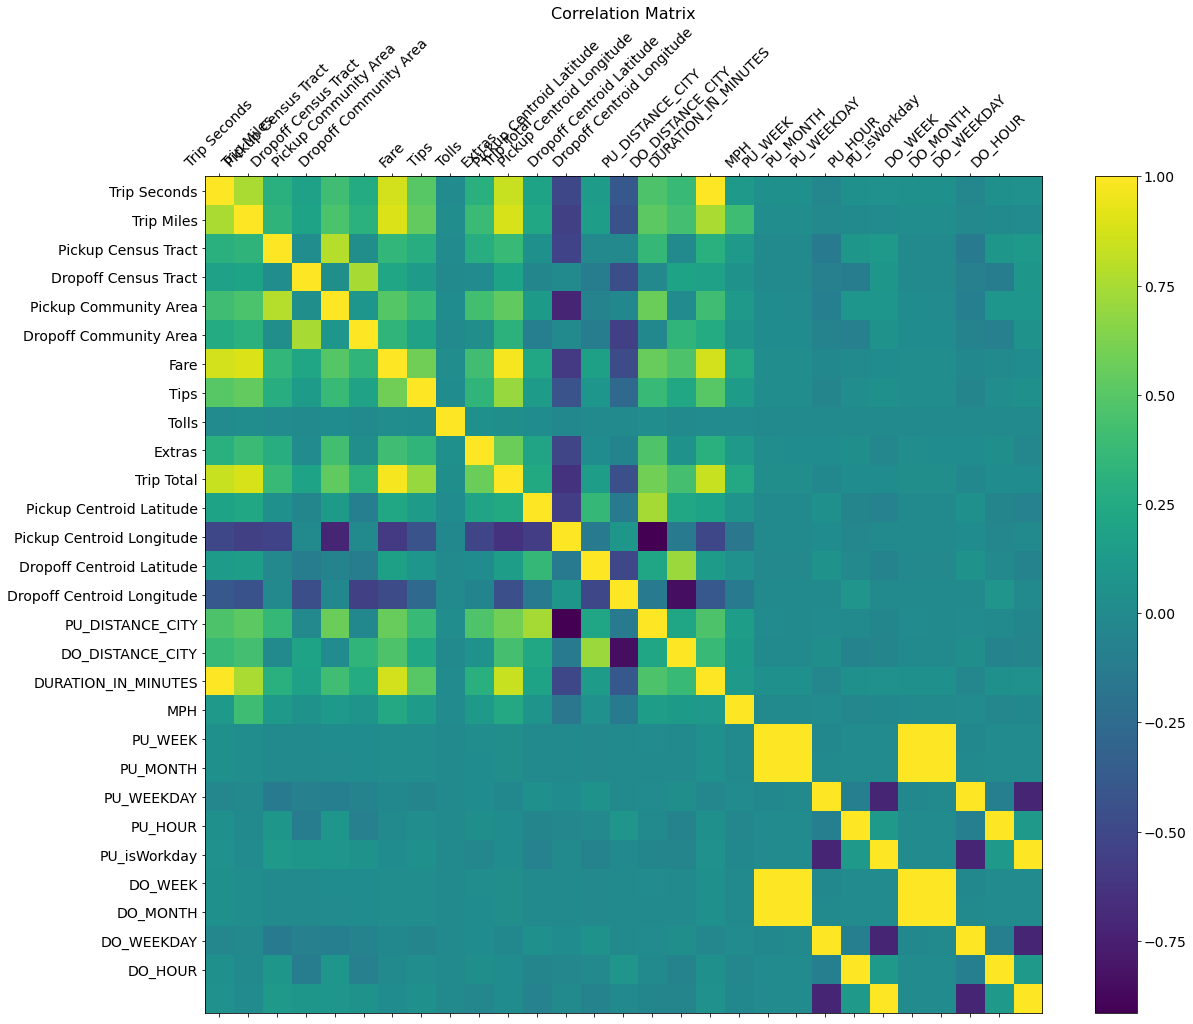

In [396]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Nun schauen wir uns die Verteilung unserer Zielvariablen taxi_demand (auf stündlicher basis) genauer an. Es ist zu erkennen, dass Samstags und Sonntags wesentlich häufiger früh am morgen das Taxi genutzt wird, als unter der Woche.

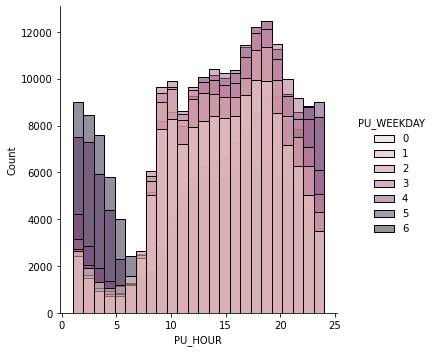

In [397]:
sns.displot(df,x='PU_HOUR', hue='PU_WEEKDAY', bins=24)


# 0. Data Preparation

The purpose of this part of the project is to build advanced models that can predict taxi demand in a certain area at a certain time frame. Consistent with the rest of the project, we use H3 coding for spatial segmentation. To get a feeling for the useful spatial resolutions that H3 offers, we start by plotting a map of chicago filled with different sized H3s to choose the relevant ones. We start with Level 9, as the data from our preprocessing (see Notebook Data Cleaning) is on Level 9, and then decrease the resolution.

In [398]:
chicago_fence=chicago.geometry[0][1]

In [399]:
chicago.head()

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1,6450276623.31,845282.931362,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."


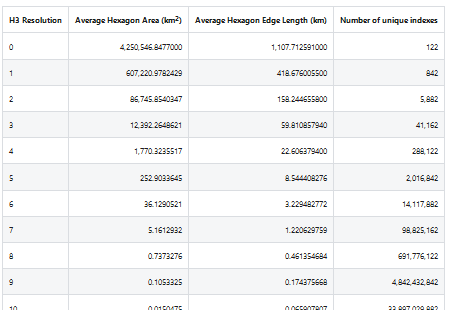

In [400]:
def get_chicago_gdf_h3(chicago_geojson,h3_res):
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id','geometry','h3_centroid'])


    # Iterate over every row of the geo dataframe
    for _,row in chicago.iterrows():  
        # Parse out info from columns of row
        district_multipolygon = row.geometry

        # Convert multi-polygon into list of polygons
        district_polygon = list(district_multipolygon)

        for polygon in district_polygon:
            # Convert Polygon to GeoJSON dictionary
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            # Parse out geometry key from GeoJSON dictionary
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            # Fill the dictionary with H3_hexagons
            h3_hexes = h3.polyfill_geojson(poly_geojson, h3_res) 
            for h3_hex in h3_hexes:
                h3_geo_boundary = shapely.geometry.Polygon(
                    h3.h3_to_geo_boundary(h3_hex,geo_json=True)
                )
                h3_centroid = h3.h3_to_geo(h3_hex)
                # Append results to dataframe
                h3_df.loc[len(h3_df)]=[
                    h3_hex,
                    h3_geo_boundary,
                    h3_centroid
                ]
    return h3_df

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(16,16))

h3_level = 9
for row in axes:
    for ax in row:
        h3_gdf = gpd.GeoDataFrame(get_chicago_gdf_h3(chicago, h3_level))
        h3_gdf.plot(ax=ax)
        ax.set_title("H3 Resolution:"+str(h3_level))
        ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
        chicago.plot(ax=ax,alpha=0) #scaling
        
        h3_level-=1

Predicting daily or hourly taxi demand for resolution 9 seems to be a little too detailed, while resolution 6 seems not detailed enough, so we focus on predicting on resolutions 7 and 8.

In terms of temporal resolutions, we find most interesting would be either daily, hourly, or 6-hourly.

In [ ]:
df.info()

To efficiently design our models for different resolutions and with different feature sets, we set up a reuseable function that builds a prediction dataframe for the desired temporal and spatial resolution. We add options to add dummy variables for 
* weather_description (~40 weather descriptions on hourly basis), 
* POI categories (~50 different categories of POI and their count in the specific H3), 
* H3 (Dummy Variable that can catch variance that is explained by only the predicted H3 polygon)

To obtain robust values for the predictors, we use the median.

In [ ]:
def get_data(df,weather_df,df_poi,temp_resolution,spatial_resolution=False,dummy_poi_category=False,dummy_weather=False,dummy_h3=False):
    
    #Filter out all Data that doesn't have Pickup Location Data
    dff = df.copy()[df["PU_H3"].isnull()!=True]
    
    
    #---- Calculate new H3 based on specified resolution (if it is higher than resolution in dataset) -----#
    h3_base_resolution = h3.h3_get_resolution(dff["PU_H3"].iloc[0]) #get original resolution in data
    
    if h3_base_resolution<spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in dataset. Keeping data on resolution",h3_base_resolution)
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if h3_base_resolution == spatial_resolution:
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if spatial_resolution and spatial_resolution<h3_base_resolution:
        #calculate new H3s with centroids of old H3s
        print("recalculating H3s from Level",h3_base_resolution,"to",spatial_resolution)
        dff["PU_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],spatial_resolution),axis=1)
        dff["DO_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],spatial_resolution),axis=1)
        
    
    dff_h3 = dff.groupby(["PU_H3_pred",
                               "PU_DATE",
                               "PU_HOUR"]).agg(H3_index=("PU_H3_pred","first"),
                                               DATE_index=("PU_DATE","first"),
                                               HOUR_index=("PU_HOUR","first"),
                                               count=("PU_H3","count"),
                                               MONTH=("PU_MONTH","first"),
                                               DISTANCE_CITY=("PU_DISTANCE_CITY","median"),
                                               WEEKDAY=("PU_WEEKDAY","first"),
                                               isWorkday=("PU_isWorkday","first"))
    
    dff_h3 = pd.merge(dff_h3,weather_df,left_on=["DATE_index","HOUR_index"],right_on=["date","hour"],how="left")
        
        
    #--------------------------- Slice Hours of Days into set Temporal Resolution ---------------------------#
    # This slices the day into equal parts. Input is the amount of slices per day.
    slicer = 24 / temp_resolution
    dff_h3["PU_HOUR_slice"] = np.ceil(dff_h3["HOUR_index"]/slicer).astype(int)
    
    
    dff_grouped = dff_h3.groupby(["H3_index",
                                   "DATE_index",
                                   "PU_HOUR_slice"]).agg(H3=("H3_index","first"),
                                                         DATE=("DATE_index","first"),
                                                         HOUR_slice=("PU_HOUR_slice","first"),
                                                         count=("count","sum"),#sums over all hours in slice
                                                         MONTH=("MONTH","first"),
                                                         DISTANCE_CITY=("DISTANCE_CITY","median"),
                                                         WEEKDAY=("WEEKDAY","first"),
                                                         isWorkday=("isWorkday","first"),
                                                         Temperature=("Temperature","median"),
                                                         Humidity=("Humidity","median"),
                                                         Wspeed=("Wind Speed","median"),
                                                         has_precipitation = ("has_precipitation","sum"),
                                                         precipitation_intensity=("precipitation_intensity","max"))




    #------------------------- Weather Description Dummies ----------------------#
    if dummy_weather:
        dff_grouped=dff_grouped.drop(columns=["has_precipitation","precipitation_intensity"])
        weather_df_dummies = weather_df.copy()[["date","hour","weather_description"]]
        weather_df_dummies = pd.concat([weather_df_dummies,
                                        pd.get_dummies(weather_df["weather_description"])],
                                       axis=1)
        weather_df_dummies["hour_slice"] = np.ceil(weather_df_dummies["hour"]/slicer).astype(int)
        weather_df_dummies = weather_df_dummies.drop(columns=["weather_description","hour"])

        weather_df_dummies = weather_df_dummies.groupby(["date","hour_slice"]).sum()
        dff_grouped=pd.merge(left=dff_grouped,
                             right=weather_df_dummies,
                             left_on=["DATE","HOUR_slice"],
                             right_index=True,
                             how="left")
        
        
        
    #---------------------------------------- POI ----------------------------------------#
    #get poi to right resolution
    
    dff_poi = df_poi.copy()
    dff_poi["area"]= dff_poi.apply(lambda x: h3.geo_to_h3(x["lng"],x["lat"],spatial_resolution),axis=1)
    if dummy_poi_category:
        dff_poi = dff_poi.drop(columns=["osm_id","feature","lat","lng","intersection"])
        dff_poi_index = dff_poi["area"]
        dff_poi = pd.get_dummies(dff_poi["key"])
        dff_poi.index = dff_poi_index
        dff_poi = dff_poi.groupby("area").sum().astype(int)
    else:
        dff_poi = dff_poi.groupby("area").agg(poi_count=("area","count"))
    
        
    dff_grouped=pd.merge(dff_grouped,dff_poi,left_on="H3",right_on="area",how="left")
    

    #----------------------------------- H3 Dummies --------------------------------------#

    
    if dummy_h3:
        h3_dummies = pd.get_dummies(dff_grouped["H3"])
        dff_grouped = pd.concat([dff_grouped,
                                 h3_dummies],axis=1)

    
    
    #----------------------------------- Output ------------------------------------#
    dff_grouped = dff_grouped.drop(columns=["H3","DATE"])
    dff_grouped=dff_grouped.replace(np.nan,0)
    return dff_grouped


## Simple Decision Tree and Linear Regressions
To get a benchmark, we set up simple Decision Tree and Linear Regressions as Benchmarks for our more complex, advanced Neural Networks and SVM Regressors. We use a reduced feature set without dummy variables in order to reduce model complexity, as these are just simple benchmark models.

In [ ]:
df_pred_simple.info()

In [ ]:
df_pred_simple = get_data(df,weather_df,df_poi,6,8)

#Split off dependant and independant variable
y=df_pred_simple["count"]
X=df_pred_simple.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
tree=DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_s,y_train)
y_pred=tree.predict(X_test_s)

eval_reg(y_test,y_pred)

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_s,y_train)
y_pred=lasso.predict(X_test_s)

eval_reg(y_test,y_pred)

# 1. Neural Networks

In [ ]:
df_pred_ann = get_data(df,weather_df,df_poi,4,8,dummy_poi_category=True,dummy_weather=True,dummy_h3=True)

#Split off dependant and independant variable
y=df_pred_ann["count"]
X=df_pred_ann.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
def build_reg_nn(layers,input_shape,activation="relu",dropout=False,optimizer="adam"):
    
    model = Sequential()
    model.add(keras.Input(shape=input_shape)) #Input Layer
    
    for layer in layers: # Hidden Layers
        model.add(Dense(layer, activation=activation)) #Add Hidden Layer with specified width and activation funciton
        if dropout: #if wanted, add dropout layer with given factor
            model.add(Dropout(dropout))
  

    model.add(Dense(1,activation="relu")) #Regression Output Layer - everything below 0 doesn't make sense here

    model.compile(loss='mse',
                  metrics=[metrics.RootMeanSquaredError()],
                  optimizer=optimizer)
    
    return model

### Basic Neural Network

In [ ]:
#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try increasing the Network Depth (adding 1 hidden layer)

In [ ]:
model=build_reg_nn(layers=[64,32,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try Increasing the Network Width

In [ ]:
model=build_reg_nn(layers=[128,64],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Use Tanh Activation instead of ReLu

In [ ]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Increase Epochs

In [ ]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="relu")
model.fit(X_train_s,y_train,batch_size=16,epochs=80)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

When doing even more epochs, training loss seems to decrease further. However, there is not much change in test set performance. This indicates that the network starts to remember entries - which is considered as overfitting.

_____________________________________________________________

# Ab hier nicht mehr von mir

In [ ]:
def get_data(df, temp_resolution, spatial_resolution=False):
    
    h3_base_resolution = h3.h3_get_resolution(df["PU_H3"].iloc[0]) #get original resolution in data
    
    #Calculate new H3 based on specified resolution (if it is higher than resolution in dataset)
    if h3_base_resolution>spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in raw data")
        
    if spatial_resolution and spatial_resolution>h3_base_resolution:
    '''df["PU_H3"] = df.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],
                                                  x['Pickup Centroid Longitude'],
                                                  spatial_resolution),axis=1)
    df["PU_H3"] = df["PU_H3"].replace("0",np.nan)'''
    
    
    
    
    
    
    #
    PU_H3_dummies = pd.get_dummies(df.PU_H3)#get dummies for H3 for prediction (alternative: use H3 centroids)
    df = pd.concat([df, PU_H3_dummies], axis=1)
    
    #group by temporal and spacial resolution
    df_new = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).median()#create df based on temporal and spacial specifications
    df_new['count'] = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).size()#add demand for each unit of analysis; note that the frame is grouped by two features
    df_new.dropna(inplace=True)
    print("Dataframe after applying temporal and spacial specifications: ")#debug information
    print("Shape: ",df_new.shape)
    print("Demand description for temporal/spatial units (e.g. 2017-01-01 09:00, 8826641915fffff): ")
    #print(df_new['count'].describe())
    
    #select target and predictors
    y = df_new['count']
    X = df_new.drop('count', axis=1)
    print('Debug Information')
    print('-------------------------------')
    print("Shape Featureset/Target: ", X.shape, y.shape)
    #print(X.iloc[0])
    
    #split data
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=38)
    
    #scale data
    scaler = StandardScaler()
    scaler.fit(x_train) #fit scaler
    X_train_scaled = scaler.transform(x_train) #apply to both, train and test set
    X_test_scaled = scaler.transform(x_test)
    print("Shape after scaling trainingset: ", X_train_scaled.shape, y_train.shape)
    print("Shape after scaling testset: ", X_test_scaled.shape, y_test.shape)
    
    #select best features
    selector = SelectKBest(f_classif, k=40)
    selector.fit(X_train_scaled, y_train)
    cols = selector.get_support(indices=True)#get selected columns
    X_train_new = X_train_scaled[:,cols]#apply to train&test set
    X_test_new = X_test_scaled[:,cols]
    print("X_Train:", X_train_new.shape, "X_Test:", X_test_new.shape)
    
    return X_train_new, X_test_new, y_train, y_test

### 4.1.1 SVM Prediction

First, we define a training method and to use it for training our models. Consequently, we will start with simple models and improve them for better performance. 

In [19]:
#function to train and evaluate our models later on
import sklearn.metrics as metrics
import numpy as np

def train(model, model_name, x_train, x_test, y_train, y_test, element):
    
    print()
    print(model_name, element) # Printing model name
    print('-------------------------------')
    model.fit(x_train,y_train) # fitting the defined model
    pred = model.predict(x_test) # predicting our data

    acc = metrics.r2_score(y_test, pred) #Checking R2_Score
    print('R2_Score',acc)

    met = np.sqrt(metrics.mean_squared_error(y_test, pred)) #Calculating RMSE
    print('RMSE : ', met) 

    var = (metrics.explained_variance_score(y_test, pred)) #Calculating explained_variance_score
    print('Explained_Variance : ', var)

    error = (metrics.max_error(y_test, pred)) #Calculating Max_Error
    print('Max_Error : ', error)
    
    err = metrics.mean_absolute_error(y_test, pred) #Calculating mean_absolute_error
    print("Mean Absolute Error", err)
    print()
    print()
    
    return model_name + '($R^2={:.3f}$)'.format(acc), np.array(y_test), pred

In [20]:
#select data to start with, we use a daily level for our inital modeling 

X_train_new, X_test_new, y_train, y_test = get_data(df, temp_resolution="24H")

Dataframe after applying temporal and spacial specifications: 
Shape:  (4963, 47)
Demand description for temporal/spatial units (e.g. 2017-01-01 09:00, 8826641915fffff): 
Debug Information
-------------------------------
Shape Featureset/Target:  (4963, 46) (4963,)
Shape after scaling trainingset:  (2977, 46) (2977,)
Shape after scaling testset:  (1986, 46) (1986,)
X_Train: (2977, 40) X_Test: (1986, 40)


In [21]:
#Start without a Kernel
results=[] #save results-tuple for visualization
model_svr = SVR()
results.append(train(model_svr, "SVR", X_train_new, X_test_new,
                     y_train, y_test, "24H" ))


SVR 24H
-------------------------------
R2_Score -0.09931873004111558
RMSE :  1572.3762838301266
Explained_Variance :  0.06630141234650444
Max_Error :  7155.638653015645
Mean Absolute Error 674.1502040129623




In [22]:
#Make more complex
model_svr2 = SVR(kernel='linear')
results.append(train(model_svr2, "SVR_Linear", X_train_new, X_test_new,
                     y_train, y_test, "24H"))


SVR_Linear 24H
-------------------------------
R2_Score 0.810303693188717
RMSE :  653.1668106704607
Explained_Variance :  0.8268322309326513
Max_Error :  3909.6355806543115
Mean Absolute Error 270.7641776055762




Parameters are as follows:
**C:** It is the regularization parameter, C, of the error term.
**kernel:** It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or callable. The default value is ‘rbf’.
**degree:** It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default value is 3.
**gamma:** It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.

In [25]:
#Tune Hyperparams
from sklearn.model_selection import GridSearchCV

param_grid = { 'C':[0.1,1,100,1000],'kernel':['poly','linear'],
              'degree':[1,2,3,4,5,6],'gamma': [1e-7, 1e-4]}
grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train_new,y_train)#loop through predefined number of hyperparameters

print(grid.best_params_)
print(grid.score(X_test_new,y_test))

{'C': 100, 'degree': 1, 'gamma': 1e-07, 'kernel': 'linear'}
0.9092864736516538


In [30]:
#Run Model with tuned hyperparams
model_svr3 = SVR(kernel='linear', C=100)
results.append(train(model_svr3, "SVR_Linear", X_train_new, X_test_new,
                     y_train, y_test, "24H"))


SVR_Linear 24H
-------------------------------
R2_Score 0.9092864736516538
RMSE :  451.67982848271794
Explained_Variance :  0.909699169899579
Max_Error :  2983.1924320871794
Mean Absolute Error 186.71099375708434




### 4.1.2 Model Evaluation (Visually)

In this section, we will examine the performance of our models more closely. For this, we will look at the visual characteristics of our predictions.

In [ ]:
# Bessere Visualisierung einbauen

In [ ]:
#Create a plot comparing multiple learners
def plot(results):
    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(8, 8))
    fig.canvas.set_window_title('Predicting Chicago')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('Taxi Demand')
        subplot.set_xlabel('Time')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted')
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()
    plt.show()
    plt.savefig('plot.png')
    plt.close()

In [ ]:
plot(results)

### 4.1.3 Variation of Temporal and Spatial Resolution

In this section, we aim to explore the performance of our best model based on a variation of termporal and spatial resolutions.

In [ ]:
#TODO: Add Spatial Resolution
#77community areas
#866 census tracts (population between 0 - 10000)
#resolution 0-15, with 0 beeing the highest

In [ ]:
#generate datasets - temporal dimension
temporal_resolution_levels = ['24H', '6H', '2H', '1H']

results = []

for element in temporal_resolution_levels:
    model = SVR(kernel='linear')
    X_train_new, X_test_new, y_train, y_test = get_data(df, element)
    results.append(train(model, "SVR_Linear", X_train_new, X_test_new,
                         y_train, y_test, element))

end = timer()
print()
print("Total Notebook Runtime (s): ", end - start)

# Backup

In [ ]:
## Test
import contextily as ctx
import h3
import shapely.geometry
import geopandas as gpd


test_resolution = 6
iloc=51

PU_lat_test=df["Pickup Centroid Latitude"].iloc[iloc]
print(PU_lat_test)
PU_lng_test=df["Pickup Centroid Longitude"].iloc[iloc]
print(PU_lng_test)

point_test = shapely.geometry.Point(PU_lng_test,PU_lat_test)
point_gdf_test = gpd.GeoDataFrame(pd.DataFrame([point_test],index=[0],columns=["geometry"]))


h3_test = h3.geo_to_h3(PU_lat_test,PU_lng_test,test_resolution)
print(h3_test)

polygon_test = {"geometry":shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_test,geo_json=True))}
geo_df_test = gpd.GeoDataFrame(pd.DataFrame(polygon_test,index=[0]))

fig,ax=plt.subplots(figsize=(8,8))
geo_df_test.plot(ax=ax,alpha=0.1)
point_gdf_test.plot(ax=ax,alpha=0.8,color="red")
ctx.add_basemap(ax=ax,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago.plot(ax=ax,alpha=0.01) #das macht nur die skalierung richtig

In [ ]:
weather_df_dummies = weather_df.copy()[["date","hour","weather_description"]]
weather_df_dummies = pd.concat([weather_df_dummies,
                                pd.get_dummies(weather_df["weather_description"])],
                               axis=1)

slicer=12
weather_df_dummies["hour_slice"] = np.ceil(weather_df_dummies["hour"]/slicer).astype(int)
weather_df_dummies = weather_df_dummies.drop(columns=["weather_description","hour"])

weather_df_dummies = weather_df_dummies.groupby(["date","hour_slice"]).sum()

weather_df_dummies["sum"]=weather_df_dummies.sum(axis=1)